# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [100]:
from bs4 import BeautifulSoup
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd


In [101]:
# Url de wikipedia que vamos a analizar
resource_url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
# Para evitar que el servidor bloquee la peticion (reglas nuevas de wikipedia aparentemente)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
# ejecutamos la peticion con los header incluidos
response = requests.get(resource_url, headers=headers)

# Si la petición se ha ejecutado correctamente (código 200), entonces el contenido HTML de la página se ha podido descargar
if response:
    # Transformamos el HTML a LXML (estructurado y anidado, con forma de árbol)
    soup = BeautifulSoup(response.content, 'html')
    soup

In [102]:
#Selecionamos la primera tabla de la pagina que contiene las canciones iba a buscar por id que seria algo mas seguro y unico pero la tabla no lo tiene 
#Y sus parents son muy ambiguos esto es lo que tenia wikipedia "<table class="wikitable sortable plainrowheaders jquery-tablesorter">"
tables = soup.find_all('table')
#De la lista de tablas obtenemos la primera y nos sacamos de una vez el tbody
table = tables[0].find('tbody')
table

<tbody><tr>
<th>Rank
</th>
<th>Song
</th>
<th>Artist(s)
</th>
<th>Streams<br/>(billions)
</th>
<th>Release date
</th>
<th class="unsortable"><abbr title="References">Ref.</abbr>
</th></tr>
<tr>
<td style="text-align:center;">1
</td>
<th scope="row">"<a href="/wiki/Blinding_Lights" title="Blinding Lights">Blinding Lights</a>"
</th>
<td style="text-align:left;"><a href="/wiki/The_Weeknd" title="The Weeknd">The Weeknd</a></td>
<td style="text-align:center;">5.278</td>
<td style="text-align:right;"><span data-sort-value="000000002019-11-29-0000" style="white-space:nowrap">29 November 2019</span></td>
<td style="text-align:center;"><sup class="reference" id="cite_ref-1"><a href="#cite_note-1"><span class="cite-bracket">[</span>1<span class="cite-bracket">]</span></a></sup>
</td></tr>
<tr>
<td style="text-align:center;">2
</td>
<th scope="row">"<a href="/wiki/Shape_of_You" title="Shape of You">Shape of You</a>"
</th>
<td style="text-align:left;"><a href="/wiki/Ed_Sheeran" title="Ed Sheeran">

In [103]:
#Funcion Para limpiar el texto, quitarle las etiquetas eliminar cualquier simbolo $
#NOTA: en las instrucciones decia eliminar la "B" tambien no se si lo interprete mal o se referia a otra cosa pero lo hice sin excluirlo
def clean_text(x):
    #para no repetir la funcion dos veces la formulamos para que sirva tanto para las etiquetas td como th
    data = x.find_all(['td', 'th'])
    #recorremos los campos de la fila o la tupla
    for i in range(len(data)):
        #limpiamos
        aux = data[i].text.strip()
        if "$" in aux:
            #le quitamos cualquier simbolo $ si lo tuviera
            aux = data[i].replace('$', '')
        data[i] = aux
    return data

#sacamos todas las filas TR
rows = table.find_all('tr')
#las de la primera posicion seran los nombres de las columnas
headers = rows[0: 1]
#el restante bueno el resto de filas valga la redundancia
tuples = rows[1:]
#convertimos ambas en listas y los mapeamos con la funcion que explicamos antes
#como el header va a ser una sola fila accedemos a el de una vez con [0]
headers = list(map(clean_text, headers))[0]
tuples = list(map(clean_text, tuples))
#el jupiter por alguna razon solo imprime automaticamente la ultima variable asi que le colocamos el print a los headers
print(headers)
tuples

['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.']


[['1', '"Blinding Lights"', 'The Weeknd', '5.278', '29 November 2019', '[1]'],
 ['2', '"Shape of You"', 'Ed Sheeran', '4.769', '6 January 2017', '[2]'],
 ['3',
  '"Sweater Weather"',
  'The Neighbourhood',
  '4.381',
  '3 December 2012',
  '[3]'],
 ['4',
  '"Starboy"',
  'The Weeknd and Daft Punk',
  '4.365',
  '21 September 2016',
  '[4]'],
 ['5', '"As It Was"', 'Harry Styles', '4.248', '1 April 2022', '[5]'],
 ['6',
  '"Someone You Loved"',
  'Lewis Capaldi',
  '4.224',
  '8 November 2018',
  '[6]'],
 ['7',
  '"Sunflower"',
  'Post Malone and Swae Lee',
  '4.120',
  '18 October 2018',
  '[7]'],
 ['8',
  '"One Dance"',
  'Drake with Wizkid and Kyla',
  '4.038',
  '5 April 2016',
  '[8]'],
 ['9', '"Perfect"', 'Ed Sheeran', '3.829', '3 March 2017', '[9]'],
 ['10',
  '"Stay"',
  'The Kid LAROI and Justin Bieber',
  '3.798',
  '9 July 2021',
  '[10]'],
 ['11', '"Believer"', 'Imagine Dragons', '3.744', '1 February 2017', '[11]'],
 ['12', '"Heat Waves"', 'Glass Animals', '3.658', '29 June 2

In [104]:

#creamos el dataframe con pandas pasandole las tuplas y columnas de antes
df = pd.DataFrame(tuples, columns=headers)
#elimino la ultima columna "Ref" porque por alguna razon no se capturo bien
#deberia lucir algo asi:<sup id="cite_ref-1" class="reference"><a href="#cite_note-1"><span class="cite-bracket">[</span>1<span class="cite-bracket">]</span></a></sup>
#pero creo que wikipedia no lo envia al menos no por este metodo quizas con selenium si
df = df.iloc[:, :-1]
#eliminamos las filas que tienen valores nulos
df = df.replace('', pd.NA)
df = df.dropna(how = 'any')
#esta funcion convierte la fecha a un formato YYYY-MM-DD que sqlite acepta mejor
def convertir_fecha(fecha_str):
    fecha = datetime.strptime(fecha_str, "%d %B %Y")
    return fecha.strftime("%Y-%m-%d")
#aplicamos la conversion con el metodo apply pasandole la funcion
df["Release date"] = df["Release date"].apply(convertir_fecha)
#nos aseguramos que sea float 2 decimales esta columna lo hacemos con lamda porque la funcion es mas corta que la anterior
df["Streams(billions)"] = df["Streams(billions)"].apply(lambda x: round(float(x),2))
df

,Rank,Song,Artist(s),Streams(billions),Release date
0,1,"""Blinding Lights""",The Weeknd,5.28,2019-11-29
1,2,"""Shape of You""",Ed Sheeran,4.77,2017-01-06
2,3,"""Sweater Weather""",The Neighbourhood,4.38,2012-12-03
3,4,"""Starboy""",The Weeknd and Daft Punk,4.37,2016-09-21
4,5,"""As It Was""",Harry Styles,4.25,2022-04-01
...,...,...,...,...,...
95,96,"""Payphone""",Maroon 5 and Wiz Khalifa,2.55,2012-04-16
96,97,"""Dreams""",Fleetwood Mac,2.55,1977-02-04
97,98,"""Sicko Mode""",Travis Scott and Drake,2.53,2018-08-21
98,99,"""Billie Jean""",Michael Jackson,2.52,1982-11-29


In [105]:
#creamos la base de datos y si ya existe la inicializa
conn = sqlite3.connect("spotify_rank.db")
#la query para crear la tabla
query = """CREATE TABLE IF NOT EXISTS spotify_rank (
    id INTEGER PRIMARY KEY,
    rank INTEGER,
    song TEXT,
    artist TEXT,
    streams REAL,
    release_date DATE
);
"""
#creamos un cursor para porder ejecutar las consultas, importante no mezclarlos entre consultas
cur = conn.cursor()
#ejecutamos y confimamos con commit
cur.execute(query)
conn.commit()
#delete para que cada ves que se ejecute este codigo no haya nada en la tabla antes de hacer los inserts
delete_query = """
DELETE FROM spotify_rank WHERE 1
"""
cur = conn.cursor()
cur.execute(delete_query)
conn.commit()

In [106]:
cur = conn.cursor()
#leemos el dataframe con for e itertuples luego construimos un insert para cada tupla o fila acedemos a los valores por su index
for tupla in df.itertuples():
    query=f"""
    INSERT INTO spotify_rank VALUES ({tupla[0]}, {tupla[1]}, {tupla[2]}, "{tupla[3]}", {float(tupla[4])}, "{tupla[5]}");
    """
    cur.execute(query)
#ejecutamos el commit solo cuando finalice el for para no hacerlo cada vez que itere   
conn.commit()
#cerramos finalmente la conexion
conn.close()


In [107]:
#finalemte hacemos una consulta select normal para comprobar si se insertaron los datos bien
conn = sqlite3.connect("spotify_rank.db")
cur = conn.cursor()
query_test = """
SELECT * FROM spotify_rank
""" 
result = cur.execute(query_test).fetchall()
print(result)
conn.close()

[(0, 1, 'Blinding Lights', 'The Weeknd', 5.28, '2019-11-29'), (1, 2, 'Shape of You', 'Ed Sheeran', 4.77, '2017-01-06'), (2, 3, 'Sweater Weather', 'The Neighbourhood', 4.38, '2012-12-03'), (3, 4, 'Starboy', 'The Weeknd and Daft Punk', 4.37, '2016-09-21'), (4, 5, 'As It Was', 'Harry Styles', 4.25, '2022-04-01'), (5, 6, 'Someone You Loved', 'Lewis Capaldi', 4.22, '2018-11-08'), (6, 7, 'Sunflower', 'Post Malone and Swae Lee', 4.12, '2018-10-18'), (7, 8, 'One Dance', 'Drake with Wizkid and Kyla', 4.04, '2016-04-05'), (8, 9, 'Perfect', 'Ed Sheeran', 3.83, '2017-03-03'), (9, 10, 'Stay', 'The Kid LAROI and Justin Bieber', 3.8, '2021-07-09'), (10, 11, 'Believer', 'Imagine Dragons', 3.74, '2017-02-01'), (11, 12, 'Heat Waves', 'Glass Animals', 3.66, '2020-06-29'), (12, 13, 'Lovely', 'Billie Eilish and Khalid', 3.65, '2018-04-19'), (13, 14, 'I Wanna Be Yours', 'Arctic Monkeys', 3.6, '2013-09-09'), (14, 15, 'Closer', 'The Chainsmokers and Halsey', 3.6, '2016-07-29'), (15, 16, 'The Night We Met', 'L

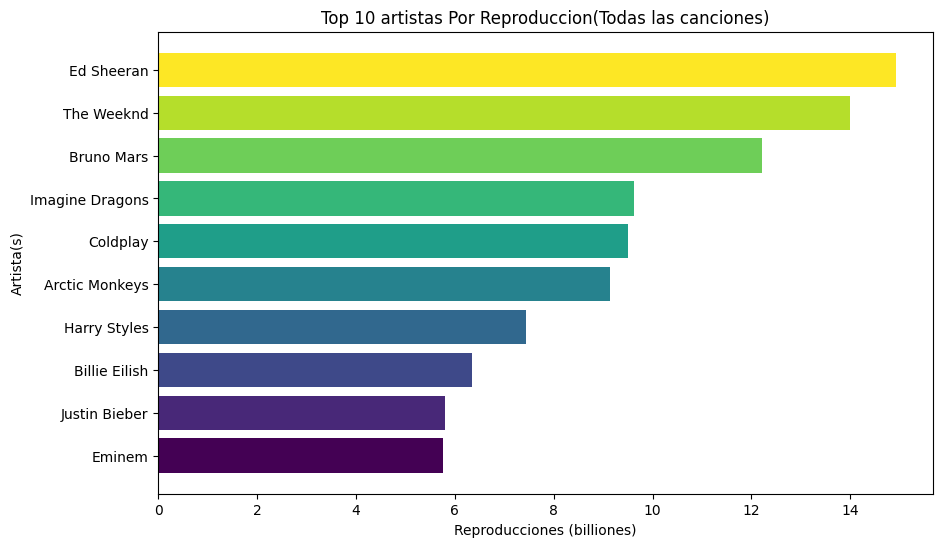

In [108]:
# para los graficos usamos los colores viridis que se usan mucho para medir la temperatura con camaras termicas
colors = [
    "#440154",
    "#482878",
    "#3e4989",
    "#31688e",
    "#26828e",
    "#1f9e89",
    "#35b779",
    "#6ece58",
    "#b5de2b",
    "#fde725"
]
# el primer grafico sera Top 10 artistas Por Reproduccion
top10_streams = (
    #primero agrupamos por artista y tomamos la columna Streams
    df.groupby("Artist(s)")["Streams(billions)"]
      .sum()  #hacemos la sumatoria de los valores de la columna Stream por artista
      .sort_values(ascending = False) #ordenamos primero para sacar los primeros 10
      .head(10)
      .sort_values(ascending = True) #ordenamos a la inversa para que en el grafico el de mayor valor se muestre primero
      .reset_index() #reseteamos el index para que empiece desde 0
)

plt.figure(figsize = (10, 6))
#grafico de barras horizontales el primer parametro el eje Y el segundo el eje X y le damos los colores viridis
plt.barh(top10_streams["Artist(s)"], top10_streams["Streams(billions)"], color = colors)
plt.xlabel("Reproducciones (billiones)")
plt.ylabel("Artista(s)")
plt.title("Top 10 artistas Por Reproduccion(Todas las canciones)")
plt.show()

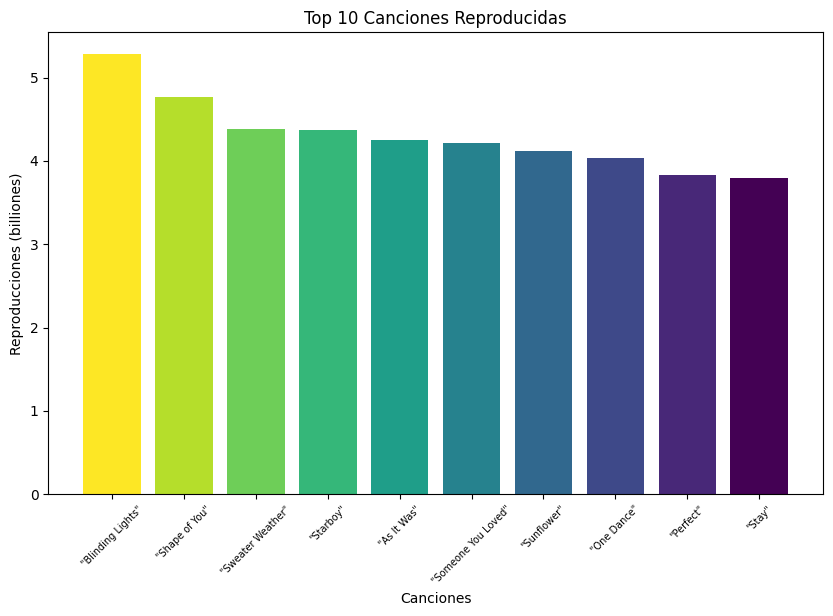

In [109]:

#Este grafico es mas sencillo no hace falta agrupar porque lo que nos itereza es el Top 10 Canciones Reproducidas
top10_songs = (
    df.sort_values("Streams(billions)",ascending = False)
      .head(10)
      .reset_index()
)
plt.figure(figsize = (10, 6))
plt.bar(top10_songs["Song"], top10_songs["Streams(billions)"],color = colors[:: -1])
plt.ylabel("Reproducciones (billiones)")
plt.xlabel("Canciones")
#en este caso cambiamos un poco la rotacion de los nombres de las canciones y le ponemos una letra mas pequeña
plt.xticks(rotation = 45, fontsize = 7)
plt.title("Top 10 Canciones Reproducidas")
plt.show()

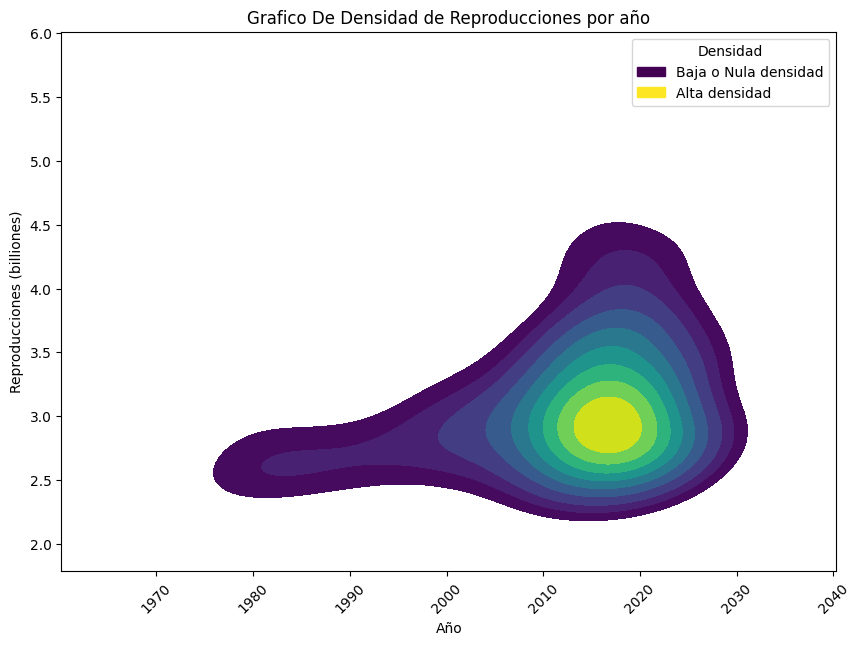

In [110]:
# convertimos y adaptamos la columna fecha para seaborn
df["Release date"] = pd.to_datetime(df["Release date"])
plt.figure(figsize = (10,7))
#usamos un grafico de densidad cuando tenemos muchos registros filas y no se requiere agruparlos
sns.kdeplot(
    data = df, #el dataframe
    x = "Release date", #la colunma en X
    y = "Streams(billions)", #la colunma en X
    fill = True, #basicamente el relleno si colocamos false solo veriamos contornos
    cmap = "viridis", #viridis ya lo trae seaborn
    thresh = 0.15 #este valor define que tan sensible es el diagrama a la hora de pintar las zonas si el valor es mas alto pintara solo zonas con densidad fuerte
)
#acontinuancion construir una pequeña leyenda tomando colores que declaramos antes
cmin = colors[0]  
cmax = colors[-1] 
#creamos  "Patches" que se los pasaremos al mathplot
patch_min = mpatches.Patch(color=cmin, label = "Baja o Nula densidad")
patch_max = mpatches.Patch(color=cmax, label = "Alta densidad")
plt.legend(handles = [patch_min, patch_max], title = "Densidad")
plt.ylabel("Reproducciones (billiones)")
plt.xlabel("Año")
plt.title("Grafico De Densidad de Reproducciones por año")
plt.xticks(rotation = 45)
plt.show()
